In [1]:
%load_ext autoreload
%autoreload 2

In [116]:
import numpy as np
from binference.toymc_running import submit_batch_toymcs, toymc_to_sbatch_call_array, run_toymcs
from binference.utils import submit_commandline_calls
from inference_interface import toyfiles_to_numpy
import matplotlib.pyplot as plt
import scipy.stats as sps
from tqdm import tqdm
from scipy.interpolate import interp1d
import h5py
from json import loads
from glob import glob

In [3]:
generate_args_base = dict(
    ernusun_rate_multiplier = 1.,
    nrnusun_rate_multiplier = 1.,
    xe136_rate_multiplier   = 1.,
    atmnu_rate_multiplier   = 1.,
    snnu_rate_multiplier    = 1.,
    signal_rate_multiplier  = 0.,
    )
fixed_base = dict(
)  


parameters_to_vary = dict(
    wimp_mass = [4,5,6,7,8,10,15,20,30,40,50,70,100,200,300,400,1000],
    #livetime = [1,20,100,200,1000],
    #livetime = [20,100,200,1000],
    livetime = [100,200,1000],
    #inference_object_args = [{"interaction":i,"binned":True} for i in ["SI","SD_p_central","SD_n_central","WIMPPion"]],
    inference_object_args = [{"interaction":i,"binned":True} for i in ["WIMPPion"]],
    #livetime = [1000]
    )
parameters_to_zip = dict()


output_pattern = "batch_results/toymc_wimpsensiunbinned_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5"
parameters_in_common = dict(
    extra_args = [{},{"signal_rate_multiplier":0.}],
    output_filename = output_pattern,
    #inference_class_name = "binference.likelihoods.ll_cevns_1t.InferenceObject",
    inference_class_name = "darwin_likelihood.darwin_likelihood.InferenceObject",
    signal_component_name="signal",
    n_mc = 1000,
    n_batch = 5,
    execution_time = 80,
    limit_threshold = None,
    compute_confidence_interval = True,
    generate_args = generate_args_base, 
    extra_args_all = fixed_base, 
    signal_expectation = 0,
    
)

In [4]:
fnames, calls = toymc_to_sbatch_call_array(parameters_to_vary=parameters_to_vary,
                                           parameters_to_zip = parameters_to_zip,
                                           parameters_in_common=parameters_in_common)
print(len(fnames),fnames[0],fnames[-1])

filename batch_results/toymc_wimpsensiunbinned_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimpsensiunbinned_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimpsensiunbinned_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimpsensiunbinned_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimpsensiunbinned_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimpsensiunbinned_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_ex

In [41]:
if True:
    submit_commandline_calls(calls, fnames, max_jobs=400, run_if_file_exists=False)

100%|██████████| 255/255 [00:30<00:00,  8.46it/s]


In [42]:
wimp_masses = parameters_to_vary["wimp_mass"]
livetimes = parameters_to_vary["livetime"]
interactions= [d["interaction"] for d in parameters_to_vary["inference_object_args"]]
interactions = ["SI","SD_p_central","SD_n_central","WIMPPion"]
livetimesi = {lt:i for i,lt in enumerate(livetimes)}
wimp_massesi = {wm:i for i,wm in enumerate(wimp_masses)}
output_pattern = "batch_results/toymc_wimpsensiunbinned_wimpmass_{wimp_mass:d}_{interaction:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}*.hdf5"

sigmas = [-2,-1,0,1,2]
sensiss = {i:{s:np.zeros((len(livetimes),len(wimp_masses))) for s in sigmas} for i in interactions}


In [43]:
interactions

['SI', 'SD_p_central', 'SD_n_central', 'WIMPPion']

In [44]:
#toymc_wimpsensi_wimpmass_4_SI_livetime_1000.00_signal_0.00_24.hdf5

In [45]:
livetimes

[100, 200, 1000]

In [46]:
for interaction in interactions:
    for i,wimp_mass in enumerate(tqdm(sorted(wimp_masses))):
        for j, livetime in enumerate(sorted(livetimes)):
            try:
                res = toyfiles_to_numpy(output_pattern.format(wimp_mass=wimp_mass,interaction=interaction,livetime=livetime,signal_expectation = 0.))
                uls = res["0"]["ul"]
                for s in sigmas:
                    sensiss[interaction][s][j][i] = np.percentile(uls,100.*sps.norm().cdf(s))
            except:
                pass

100%|██████████| 17/17 [00:01<00:00,  9.48it/s]


In [19]:
sensiss

{'SD_n_central': {-2: array([[7.40564711e+05, 5.81970319e+04, 9.69987043e+03, 2.50464334e+03,
          8.60576632e+02, 1.92209286e+02, 4.32288489e+01, 2.58832329e+01,
          1.90900898e+01, 1.85550467e+01, 1.88643475e+01, 2.63825808e+01,
          2.96615488e+01, 5.63286690e+01, 8.34360957e+01, 0.00000000e+00,
          2.72218489e+02],
         [5.45272588e+05, 4.32264923e+04, 6.82121421e+03, 1.87014427e+03,
          6.33146888e+02, 1.31985451e+02, 2.87410179e+01, 1.75323851e+01,
          1.26232668e+01, 1.31918648e+01, 1.32843389e+01, 1.57763898e+01,
          2.07931120e+01, 4.06663913e+01, 6.13510605e+01, 0.00000000e+00,
          1.85228807e+02],
         [2.94100133e+05, 2.54569777e+04, 4.49306530e+03, 1.03359652e+03,
          2.95425219e+02, 6.53893870e+01, 1.08889470e+01, 6.85896932e+00,
          5.07353064e+00, 5.45872428e+00, 5.68473574e+00, 6.85331832e+00,
          8.67105563e+00, 1.58897560e+01, 2.23796217e+01, 0.00000000e+00,
          7.73228012e+01]]),
  -1: arr

In [20]:
i_wimp_mass = np.argmax(np.array(wimp_masses)==50)

In [21]:
livetimes

[100, 200, 1000]

In [22]:
sensiss["SI"][0][:,i_wimp_mass] * 257.6611145532219 * np.array(livetimes)

array([10.96908543, 14.89034847, 32.57978512])

In [23]:
sensiss["SI"][0][:,i_wimp_mass]

array([0.00042572, 0.00028895, 0.00012644])

In [24]:
uls_1t = dict()

In [25]:
lz_webplot = np.array([3.0220, 9.7995e-43,
3.1506, 5.7871e-43,
3.2805, 3.3710e-43,
3.3909, 2.4217e-43,
3.5128, 1.6198e-43,
3.6472, 9.9846e-44,
3.8370, 6.1883e-44,
3.9749, 4.2335e-44,
4.1177, 2.9623e-44,
4.2656, 2.0884e-44,
4.4188, 1.4835e-44,
4.5775, 1.0737e-44,
4.7419, 7.7425e-45,
4.9122, 5.6676e-45,
5.1111, 3.9957e-45,
5.3415, 2.7438e-45,
5.5822, 1.8842e-45,
5.8339, 1.2938e-45,
6.0969, 8.8582e-46,
6.3717, 6.1196e-46,
6.6589, 4.2531e-46,
6.9590, 2.9471e-46,
7.2727, 2.0606e-46,
7.6004, 1.4626e-46,
7.9429, 1.0475e-46,
8.3374, 7.3981e-47,
8.7901, 5.1831e-47,
9.2672, 3.7141e-47,
9.8133, 2.6349e-47,
10.437, 1.8686e-47,
11.150, 1.3370e-47,
12.016, 9.4634e-48,
13.064, 6.7384e-48,
14.329, 4.9322e-48,
15.784, 3.7938e-48,
17.388, 3.0154e-48,
19.154, 2.4767e-48,
21.099, 2.1136e-48,
23.241, 1.8537e-48,
25.601, 1.6731e-48,
28.199, 1.5583e-48,
31.061, 1.4977e-48,
34.213, 1.4694e-48,
37.685, 1.4574e-48,
41.509, 1.4474e-48,
45.722, 1.4474e-48,
50.361, 1.4694e-48,
55.470, 1.5184e-48,
61.098, 1.5797e-48,
67.296, 1.6617e-48,
74.123, 1.7671e-48,
81.642, 1.8921e-48,
89.924, 2.0287e-48,
99.046, 2.1841e-48,
109.09, 2.3578e-48,
120.16, 2.5453e-48,
132.35, 2.7403e-48,
145.77, 2.9583e-48,
160.56, 3.1936e-48,
176.85, 3.4571e-48,
194.78, 3.7474e-48,
214.54, 4.0566e-48,
236.30, 4.4032e-48,
260.27, 4.7730e-48,
286.67, 5.1739e-48,
315.75, 5.6237e-48,
347.78, 6.1294e-48,
383.06, 6.6624e-48,
421.91, 7.2317e-48,
464.71, 7.8713e-48,
511.84, 8.5673e-48,
563.76, 9.3505e-48,
620.94, 1.0261e-47,
683.92, 1.1261e-47,
753.30, 1.2340e-47,
829.70, 1.3524e-47,
913.86, 1.4922e-47,
1006.5, 1.6488e-47,
1108.6, 1.8243e-47,
1221.1, 2.0157e-47,
1344.9, 2.2272e-47,
1481.3, 2.4744e-47,
1631.6, 2.7565e-47,
1797.1, 3.0374e-47,
1993.8, 3.4641e-47,
])
lz_masses = lz_webplot[0::2]
lz_sensis = lz_webplot[1::2]
exposure = 15.3 #ty

In [26]:
np.savetxt("lz_15d3_si_1sided_proj.csv",np.vstack([lz_masses,lz_sensis]).T, delimiter=",",header="mass,sensi")

In [29]:
np.savetxt?

In [27]:
def get_curves(possible_parameters, working_point_pattern="*"):
    #this is needed since SD uses other masses, so we always have to check... Also makes 
    #runs a bit more robust to failures
    ulm2 = np.zeros(len(possible_parameters))
    ulm1 = np.zeros(len(possible_parameters))
    ulmed = np.zeros(len(possible_parameters))
    ulp1 = np.zeros(len(possible_parameters))
    ulp2 = np.zeros(len(possible_parameters))
    power3s = np.zeros(len(possible_parameters))
    power5s = np.zeros(len(possible_parameters))
    pclthresholds = np.zeros(len(possible_parameters))
    wimp_mus = np.zeros(len(possible_parameters))
    
    file_exists = np.zeros(len(possible_parameters), dtype=bool)
    
    for i, parameter in enumerate(possible_parameters): 
        try:
            if i==0:
                print(working_point_pattern.format(parameter=parameter))
            f = np.load(working_point_pattern.format(parameter=parameter), allow_pickle=True)
            dulp = f["dulps"].item()
            ulm2[i] = dulp[-2]
            ulm1[i] = dulp[-1]
            ulmed[i] = dulp[0]
            ulp1[i] = dulp[1]
            ulp2[i] = dulp[2]
            power3s[i] = float(f["power_3s"])
            power5s[i] = float(f["power_5s"])
            pclthresholds[i] = float(f["pcl_threshold_1scl90"])
            wimp_mus[i] = float(f["mu_wimp"])
            file_exists[i] = True
        except:
            pass
    if np.sum(file_exists)==0:
        print("No file found matching!")
        return None
    print(possible_parameters, file_exists)
    parameters = np.array(possible_parameters)[file_exists]
    rets = dict(ulm2 = ulm2, ulm1 = ulm1, ulmed=ulmed, ulp1=ulp1,ulp2=ulp2,
                power3s = power3s, power5s=power5s, 
                pclthresholds=pclthresholds, wimp_mus = wimp_mus)
    for k,i in rets.items():
        rets[k] = i[file_exists]
    return parameters, rets

In [28]:
possible_wimp_masses = [6,8,10,20,30,40,50,70,100,200,1000] + [5, 7, 8, 9, 10, 15, 20, 30, 40, 50, 70, 80, 100, 120, 150, 200, 300, 500, 700, 1000, 3300, 10000]
working_point_pattern = ("/home/kmoraa/scratch-midway/nt_MC_paperplots/MC_WIMP_Sensitivity_Paper/projections/v{version:s}/projection_v{version:s}_{exposure:.2f}ty_{interaction:s}"
                         "_wimp_mass_{{parameter:d}}_er_nTSR0_rate_multiplier_1.00"
                         "_h3_nTSR0_rate_forced_0.00_radiogenic_nTSR0_rate_multiplier_1.00_{sides:d}sided_"
                         "signal_expectation_0.00.npz")

In [32]:
ntproj = get_curves(possible_wimp_masses, working_point_pattern=working_point_pattern.format(version = "0.8", exposure = 20., interaction = "SI",sides=2 ))
#ntproj[1]["ulmed"]

/home/kmoraa/scratch-midway/nt_MC_paperplots/MC_WIMP_Sensitivity_Paper/projections/v0.8/projection_v0.8_20.00ty_SI_wimp_mass_6_er_nTSR0_rate_multiplier_1.00_h3_nTSR0_rate_forced_0.00_radiogenic_nTSR0_rate_multiplier_1.00_2sided_signal_expectation_0.00.npz
[6, 8, 10, 20, 30, 40, 50, 70, 100, 200, 1000, 5, 7, 8, 9, 10, 15, 20, 30, 40, 50, 70, 80, 100, 120, 150, 200, 300, 500, 700, 1000, 3300, 10000] [ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [34]:
f = np.load("/home/kmoraa/cevns_binference2//older_limits/cached_ul_151m_SR10.npz",allow_pickle=True)
sr1uld = f["uls"].item()
sr1masses = sorted(sr1uld.keys())
sr1lims = [sr1uld[m]*1e-45 for m in sr1masses]
uls_1t["SI"] = sr1masses, sr1lims
a = np.loadtxt("sd_n_only_limit.csv",delimiter=",")
uls_1t["SD_n_central"] = a[:,0],a[:,1]
a = np.loadtxt("sd_p_only_limit.csv",delimiter=",")
uls_1t["SD_p_central"] = a[:,0],a[:,1]

In [35]:
np.savetxt("xe1t_si_limit.csv",np.vstack([sr1masses, sr1lims]).T,delimiter=",")

In [36]:
f = np.load("nufloor.npz",allow_pickle=True)
nuf_mass = f["wimp_masses"]
nuf = f["floors"].item()

In [37]:
np.savez("darwin_projection_curves.npz",sensiss=sensiss,
                                       sensi_livetimes = livetimes, 
                                       sensi_masses = wimp_masses,
                                       nuf_masses = nuf_mass,
                                       nuf = nuf,
                                       ntproj = ntproj,
                                       
                                       )

In [94]:
it = 0

In [95]:
livetimesi.keys()

dict_keys([200, 100, 20, 1000])

In [96]:
from matplotlib.cm import get_cmap
cmap = get_cmap("viridis_r")

In [98]:
def plot_interpolated_limit(wm,sensi,wmplot,**kwargs):
    f = interp1d(np.log10(wm),np.log10(sensi),bounds_error = False, fill_value = np.inf)
    plt.plot(wmplot, 10**f(np.log10(wmplot)),**kwargs)
    

In [101]:
plot_livetimes = [100,1000]

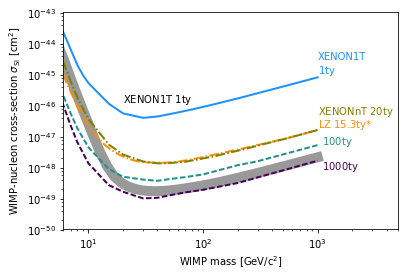

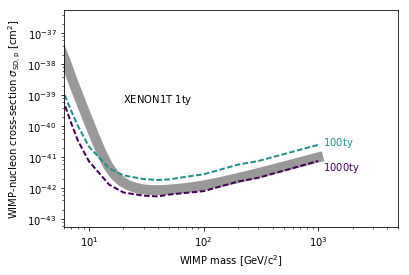

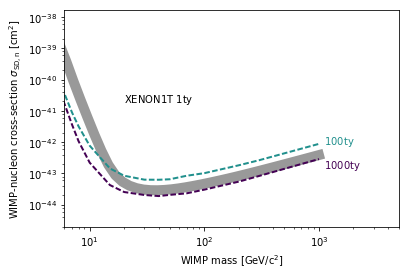

In [102]:
interaction = "SD_p_central"
interaction = "SI"
for interaction in interactions:
    iname = interaction.split("_")[0]
    try:
        iname += "," +interaction.split("_")[1] 
    except:
        pass
    sensis = sensiss[interaction]
    plt.clf()
    plot_interpolated_limit(nuf_mass,nuf[interaction],nuf_mass,linewidth=10,linestyle="-",alpha=0.4,color="k")
    if interaction == "SI":
        plot_wimp_masses = np.logspace(np.log10(6),3,1000)
        plot_interpolated_limit(uls_1t[interaction][0],uls_1t[interaction][1],plot_wimp_masses,color="dodgerblue")
        plot_interpolated_limit(lz_masses, lz_sensis,plot_wimp_masses,linestyle="-.",color="darkorange")
        plot_interpolated_limit(ntproj[0],ntproj[1]["ulmed"]*1e-45,plot_wimp_masses,linestyle="-.",color="olive")
        #f_xe1t_ul = interp1d(np.log10(uls_1t[interaction][0],uls_1t[interaction][1],bounds_error=False, fill_value=np.inf)
        #plt.plot(plot_wimp_masses, f_xe1t_ul(plot_wimp_masses) , color="k",linestyle="-",label="1T SI")
        #
        #f_lz15d3_sensi = interp1d(lz_masses, lz_sensis,bounds_error=False, fill_value=np.inf)
        #plt.plot(plot_wimp_masses, f_lz15d3_sensi(plot_wimp_masses) , color="k",linestyle="-",label="LZ 15.3*")
        plt.text(1000,1e-45,"XENON1T\n$1\mathrm{ty}}$",color="dodgerblue")
        plt.text(1000,5e-47,"XENONnT $20\mathrm{ty}}$",color="olive")
        plt.text(1000,2e-47,"LZ $15.3\mathrm{ty}}$*",color="darkorange")
        
    plt.text(20,3*np.min(uls_1t[interaction][1]),"XENON1T $1\mathrm{ty}$")
    for livetime in plot_livetimes:
        it = livetimesi[livetime]
        color = cmap((it+1)/(len(livetimes)+1))
        plt.plot(wimp_masses,sensis[0][it]*1e-45,color=color,linestyle="--")
        if livetime<1000:
            offset = 1.
        else:
            offset = 0.5
        plt.text(1100,offset * sensis[0][it][-1]*1e-45,"${:.0f} \mathrm{{ty}}$".format(livetime),color=color)
    plt.yscale("log")
    plt.xscale("log")
    #plt.ylim(1e-50,1e-41)
    plt.ylim(np.min(sensis[0][-1])*0.1*1e-45,np.max(sensis[2][0])*1e-45)
    #plt.ylim(1e-51,1e-40)
    plt.xlim(6,5000)
    plt.ylabel("WIMP-nucleon cross-section $\\sigma_\\mathrm{" +iname+ "}$ [cm$^2$]")
    plt.xlabel("WIMP mass [GeV/c$^2$]")
    for fmt in [".png",".pdf"]:
        plt.savefig("darwin_projection_{:s}_vsmass.{:s}".format(interaction,fmt))
    plt.show()
    

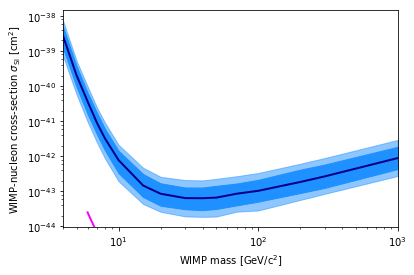

In [103]:
plt.clf()
livetime = 100.
it = livetimesi[livetime]
plt.plot(sr1masses, sr1lims , color="magenta",linestyle="-",label="1T SI")
plt.fill_between(wimp_masses,sensis[-2][it]*1e-45,sensis[2][it]*1e-45,color="dodgerblue",alpha=0.5)
plt.fill_between(wimp_masses,sensis[-1][it]*1e-45,sensis[1][it]*1e-45,color="dodgerblue")
plt.plot(wimp_masses,sensis[0][it]*1e-45,color="darkblue")
plt.yscale("log")
plt.ylim(np.min(sensis[-2][it])*0.5*1e-45,np.max(sensis[2][it])*2*1e-45)
plt.xlim(4,1000)
plt.xscale("log")
plt.ylabel("WIMP-nucleon cross-section $\\sigma_\\mathrm{SI}$ [cm$^2$]")
plt.xlabel("WIMP mass [GeV/c$^2$]")
plt.show()

In [105]:
livetimes

[100, 200, 1000]

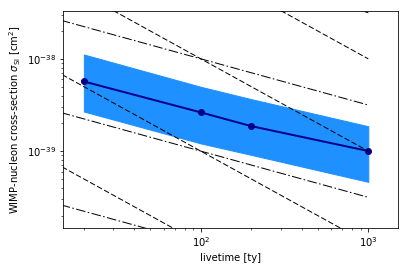

In [116]:
plt.clf()
wimp_mass = 4
wmi = wimp_massesi[wimp_mass]
interaction = "SD_n_central"
sensis = sensiss[interaction]
#plt.plot(sr1masses, sr1lims , color="magenta",linestyle="-",label="1T SI")
#plt.fill_between(wimp_masses,sensis[-2][it]*1e-45,sensis[2][it]*1e-45,color="dodgerblue",alpha=0.5)
#plt.fill_between(wimp_masses,sensis[-1][it]*1e-45,sensis[1][it]*1e-45,color="dodgerblue")
plt.fill_between(livetimes,sensis[-1][:,wmi]*1e-45,sensis[1][:,wmi]*1e-45,color="dodgerblue")
plt.plot(livetimes,sensis[0][:,wmi]*1e-45,color="darkblue")
plt.scatter(livetimes,sensis[0][:,wmi]*1e-45,color="darkblue")
x = np.logspace(0,3,100)
for ex,ls in zip([-1., -0.5],["--","-."]):
    for si in np.logspace(-50,-30,21):
        plt.plot(x,si * x**ex,linestyle=ls,color="k",linewidth=1)
plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-50,1e-41)
plt.ylim(sensis[-2][-1,wmi]*0.5*1e-45,sensis[2][0,wmi]*2*1e-45)
plt.xlim(15,1500)
plt.ylabel("WIMP-nucleon cross-section $\\sigma_\\mathrm{SI}$ [cm$^2$]")
plt.xlabel("livetime [ty]")
plt.show()

In [66]:
generate_args_base = dict(
    ernusun_rate_multiplier = 1.,
    nrnusun_rate_multiplier = 1.,
    xe136_rate_multiplier   = 1.,
    atmnu_rate_multiplier   = 1.,
    snnu_rate_multiplier    = 1.,
    signal_rate_multiplier  = 0.,
    )
fixed_base = dict(
)  


parameters_to_vary = dict(
    #wimp_mass = [4,5,6,7,8,10,15,20,30,40,50,70,100,200,300,400,1000],
    wimp_mass = [4,5,6,7,8,10],
    #livetime = [1,20,100,200,1000],
    #livetime = [20,100,200,1000],
    livetime = [100,200,1000],
    #signal_expectation = np.linspace(0,300,31),
    signal_expectation = np.linspace(0,2000,21),
    #inference_object_args = [{"interaction":i,"binned":True} for i in ["SI","SD_p_central","SD_n_central","WIMPPion"]],
    #livetime = [1000]
    )
parameters_to_zip = dict()


output_pattern = "batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5"
parameters_in_common = dict(
    extra_args = [{},{"signal_rate_multiplier":0.}],
    output_filename = output_pattern,
    #inference_class_name = "binference.likelihoods.ll_cevns_1t.InferenceObject",
    inference_class_name = "darwin_likelihood.darwin_likelihood.InferenceObject",
    signal_component_name="signal",
    n_mc = 1000,
    n_batch = 1,
    execution_time = 80,
    limit_threshold = None,
    compute_confidence_interval = False,
    generate_args = generate_args_base, 
    extra_args_all = fixed_base, 
    inference_object_args = {"interaction":"SI","binned":True} ,
    
)

In [67]:
fnames, calls = toymc_to_sbatch_call_array(parameters_to_vary=parameters_to_vary,
                                           parameters_to_zip = parameters_to_zip,
                                           parameters_in_common=parameters_in_common)
print(len(fnames),fnames[0],fnames[-1])

filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc

filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
filename batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_{inference_object_args[interaction]:s}_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}.hdf5
378 batch_results/toymc_wimp

In [68]:
if True:
    submit_commandline_calls(calls, fnames, max_jobs=400, run_if_file_exists=False)

100%|██████████| 378/378 [00:48<00:00,  7.83it/s]


In [75]:
signal_expectations

[0.0,
 10.0,
 20.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0,
 110.0,
 120.0,
 130.0,
 140.0,
 150.0,
 160.0,
 170.0,
 180.0,
 190.0,
 200.0,
 210.0,
 220.0,
 230.0,
 240.0,
 250.0,
 260.0,
 270.0,
 280.0,
 290.0,
 300.0,
 400.0,
 500.0,
 600.0,
 700.0,
 800.0,
 900.0,
 1000.0,
 1100.0,
 1200.0,
 1300.0,
 1400.0,
 1500.0,
 1600.0,
 1700.0,
 1800.0,
 1900.0,
 2000.0]

In [117]:
def getmu(fpat="*.hdf5",component="signal"):
    fn = glob(fpat)[0]
    ret = -1
    with h5py.File(fn) as f:
        ret = loads(f.attrs["nominal_expectations"])
    if component is not None:
        ret = ret[component]
    return ret

In [124]:
output_pattern = "batch_results/toymc_wimppower_wimpmass_{wimp_mass:d}_SI_livetime_{livetime:.2f}_signal_{signal_expectation:.2f}*.hdf5"
power_dict = dict()
wimp_masses = [4,5,6,7,8,10,15,20,30,40,50,70,100,200,300,400,1000]
livetimes= [100,200,1000]
signal_expectations = sorted(set(np.concatenate([np.linspace(0,300,31),
                                                 np.linspace(0,2000,21)])))
for wimp_mass in tqdm(wimp_masses):
    for livetime in livetimes:
        for sigmat in [3,5]:
            llr_threshold = sps.chi2(1).isf(2.*sps.norm().sf(sigmat)) # asymptotic chernov llr discovery threshold
            mus = []
            powers = []
            nominal_expectation = -1
            for signal_expectation in signal_expectations:
                try:
                    fns = output_pattern.format(wimp_mass = wimp_mass,
                                               livetime=livetime, 
                                               signal_expectation = signal_expectation)
                    res = toyfiles_to_numpy(fns)
                    llrs = 2*(res["0"]["ll"] - res["1"]["ll"])
                    power = np.mean(llr_threshold < llrs)
                    nominal_expectation = getmu(fns,"signal")
                    mus.append(signal_expectation)
                    powers.append(power)
                except:
                    pass
            power_dict[wimp_mass, livetime,sigmat] = (nominal_expectation,np.array(mus),np.array(powers))

100%|██████████| 17/17 [01:38<00:00,  5.81s/it]


In [128]:
medpower_dict = dict()
for livetime in livetimes:
    for sigmat in [3,5]:
        wms = []
        sigmas = []
        for wimp_mass in wimp_masses:
            musig,x,y = power_dict[wimp_mass, livetime,sigmat]
            fint = interp1d(y,1e-45*x/musig,bounds_error=False,fill_value=np.inf)
            sigma = fint(0.5)
            wms.append(wimp_mass)
            sigmas.append(sigma)
        medpower_dict[livetime,sigmat] = np.array(wms), np.array(sigmas)
        
        

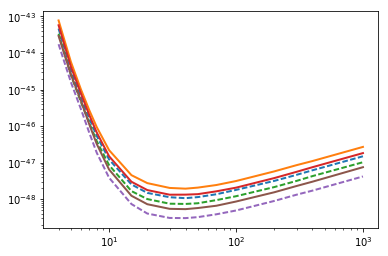

In [129]:
plt.clf()
for livetime in livetimes:
    for sigmat in [3,5]:
        x,y = medpower_dict[livetime,sigmat]
        if sigmat == 3:
            linestyle="--"
        else:
            linestyle="-"
        plt.plot(x,y,linestyle=linestyle)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [130]:
np.savez("medpower_results.npz",medpower_dict = medpower_dict)

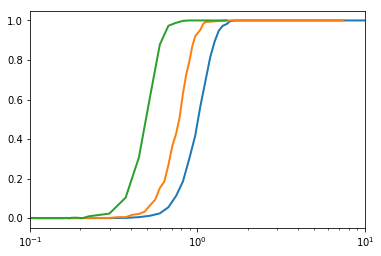

In [121]:
plt.clf()
wimp_mass = 6
for livetime in livetimes:
    musig,x,y = power_dict[wimp_mass, livetime]
    plt.plot(x/musig,y)
plt.xscale("log")
plt.xlim(0.1,10)
plt.show()

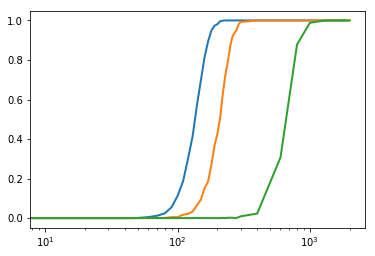

In [97]:
plt.clf()
wimp_mass = 6
for livetime in livetimes:
    x,y = power_dict[wimp_mass, livetime]
    plt.plot(x,y)
plt.xscale("log")
#plt.xlim(0.1,2000)
plt.show()

In [38]:
x,y

(array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200.]),
 array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ]))

In [23]:
sps.chi2(1).isf(2*sps.norm().sf(5))

25.000000000000004

In [99]:
fn = output_pattern.format(wimp_mass=6, livetime=100., signal_expectation = 200)

In [ ]:
deg 

In [105]:
fn = glob(fn)[0]

In [106]:
fn

'batch_results/toymc_wimppower_wimpmass_6_SI_livetime_100.00_signal_200.00_0.hdf5'

In [114]:
with h5py.File(fn) as f:
    print(list(f.attrs.keys()))
    print(f.attrs["nominal_expectations"])

['nominal_expectations', 'signal_expectation', 'version', 'signal_component_name', 'generate_args', 'date']
{"xe136": 2387.192563574009, "ernusun": 4743.190594088911, "atmnu": 4.26829218468601, "snnu": 0.8984795238390717, "signal": 134.2659906921072, "nrnusun": 549.0770989959811}


In [63]:
res = toyfiles_to_numpy(output_pattern.format(wimp_mass=6, livetime=100., signal_expectation = 200))

In [64]:
llrs = 2*(res["0"]["ll"] - res["1"]["ll"])

In [65]:
np.mean(llr_threshold<llrs)

0.981